In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window


In [0]:
raw_df = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("dbfs:/FileStore/tables/database_gb.csv")
)

raw_df.printSchema()


root
 |-- ano_mes: date (nullable = true)
 |-- cod_material: string (nullable = true)
 |-- des_material: string (nullable = true)
 |-- des_familia: string (nullable = true)
 |-- cod_tipo_material: string (nullable = true)
 |-- unidade_medida: string (nullable = true)
 |-- des_categoria_demanda: string (nullable = true)
 |-- vlr_consumo_realizado: double (nullable = true)
 |-- qtd_realizada: double (nullable = true)
 |-- qtd_prevista: double (nullable = true)



In [0]:
%sql
CREATE DATABASE IF NOT EXISTS SANDBOX

In [0]:
(
    raw_df
    .write
    .mode("overwrite")
    .format("delta")
    .saveAsTable("sandbox.consumo_material_base")
)


##ACURACIDADE DOS DADOS

In [0]:
%sql

SELECT 
    MIN(ano_mes) as data_inicio,
    MAX(ano_mes) as data_fim,
    COUNT(DISTINCT cod_material) as total_skus,
    COUNT(DISTINCT des_familia) as total_familias,
    COUNT(DISTINCT des_categoria_demanda) as categorias_demanda
FROM sandbox.consumo_material_base;


SELECT 
    COUNT(*) as total_linhas,
    SUM(CASE WHEN qtd_realizada IS NULL THEN 1 ELSE 0 END) as nulos_realizado,
    SUM(CASE WHEN qtd_prevista IS NULL THEN 1 ELSE 0 END) as nulos_previsto
FROM sandbox.consumo_material_base;

total_linhas,nulos_realizado,nulos_previsto
11171,0,0


In [0]:
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
import pyspark.sql.functions as F

df = spark.table("sandbox.consumo_material_base")

df.select(
    F.sum("vlr_consumo_realizado").alias("consumo_total")
).show()


+--------------------+
|       consumo_total|
+--------------------+
|4.2599544058799996E9|
+--------------------+



In [0]:
pareto_df = (
    df.groupBy("des_material")
      .agg(F.sum("vlr_consumo_realizado").alias("consumo"))
      .orderBy(F.desc("consumo"))
)

pareto_pd = pareto_df.toPandas()

pareto_pd["acumulado"] = pareto_pd["consumo"].cumsum()
pareto_pd["acumulado_pct"] = pareto_pd["acumulado"] / pareto_pd["consumo"].sum()


##FORECAST PREVISIBILIDADE

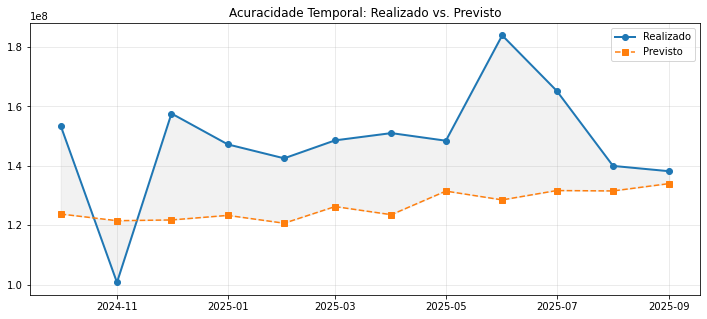

In [0]:
df_trend = spark.sql("""
    SELECT ano_mes, 
           SUM(qtd_realizada) as total_realizado,
           SUM(qtd_prevista) as total_previsto
    FROM sandbox.consumo_material_base
    GROUP BY ano_mes ORDER BY ano_mes
""").toPandas()

plt.figure(figsize=(12, 5))
plt.plot(df_trend['ano_mes'], df_trend['total_realizado'], label='Realizado', marker='o', linewidth=2)
plt.plot(df_trend['ano_mes'], df_trend['total_previsto'], label='Previsto', linestyle='--', marker='s')
plt.fill_between(df_trend['ano_mes'], df_trend['total_realizado'], df_trend['total_previsto'], color='gray', alpha=0.1)
plt.title('Acuracidade Temporal: Realizado vs. Previsto')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##PARETO

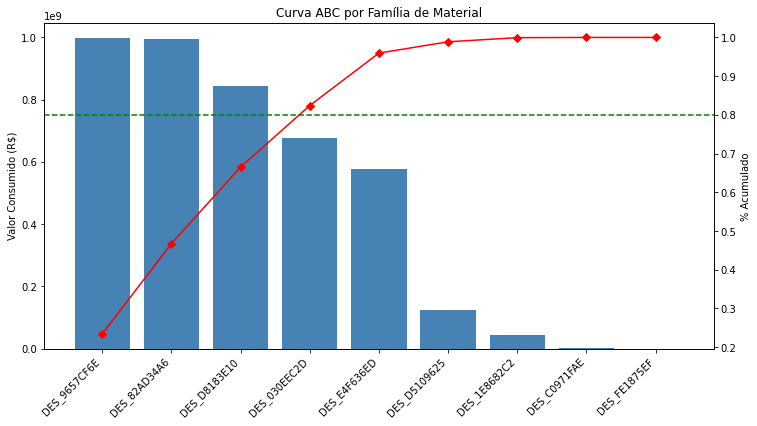

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregando os dados processados via SQL
df_abc = spark.sql("""
    WITH valorizacao AS (
        SELECT des_familia, SUM(vlr_consumo_realizado) as valor_total
        FROM sandbox.consumo_material_base
        GROUP BY 1 ORDER BY valor_total DESC
    )
    SELECT *, 
           SUM(valor_total) OVER (ORDER BY valor_total DESC) / SUM(valor_total) OVER () as pct_acumulado
    FROM valorizacao
""").toPandas()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras para valor
ax1.bar(df_abc['des_familia'], df_abc['valor_total'], color='steelblue')
ax1.set_ylabel('Valor Consumido (R$)')
plt.xticks(rotation=45, ha='right')

# Linha para acumulado
ax2 = ax1.twinx()
ax2.plot(df_abc['des_familia'], df_abc['pct_acumulado'], color='red', marker='D', ms=5)
ax2.axhline(y=0.8, color='green', linestyle='--') # Limite Curva A
ax2.set_ylabel('% Acumulado')

plt.title('Curva ABC por Família de Material')
plt.show()

##MAPE - EVOLUÇÃO DO ERRO

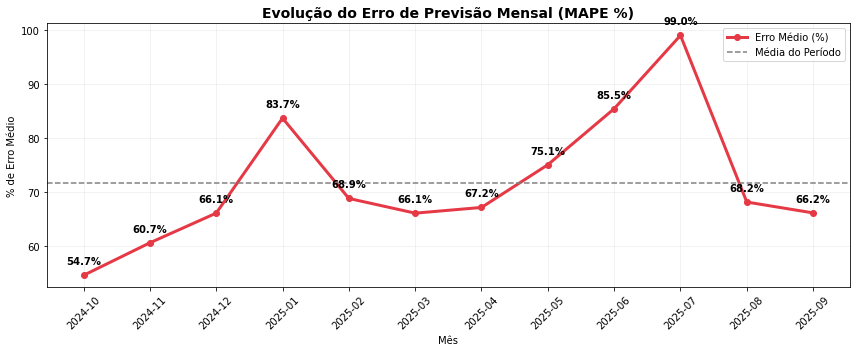

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Agregando os dados para calcular o erro médio mensal via SQL
df_erro_mensal = spark.sql("""
    SELECT 
        date_format(ano_mes, 'yyyy-MM') as mes,
        -- Calculando o MAPE Mensal (Média dos erros percentuais)
        AVG(ABS(qtd_realizada - qtd_prevista) / NULLIF(qtd_prevista, 0)) * 100 as erro_percentual_medio
    FROM sandbox.consumo_material_base
    WHERE qtd_prevista > 0
    GROUP BY 1 ORDER BY 1
""").toPandas()

# 2. Criando o gráfico de linha simples e direto
plt.figure(figsize=(12, 5))

plt.plot(df_erro_mensal['mes'], df_erro_mensal['erro_percentual_medio'], 
         marker='o', color='#E63946', linewidth=3, label='Erro Médio (%)')

# Estética Executiva
plt.title('Evolução do Erro de Previsão Mensal (MAPE %)', fontsize=14, fontweight='bold')
plt.xlabel('Mês')
plt.ylabel('% de Erro Médio')
plt.axhline(df_erro_mensal['erro_percentual_medio'].mean(), color='gray', linestyle='--', label='Média do Período')
plt.grid(True, alpha=0.2)
plt.xticks(rotation=45)
plt.legend()

# Adicionando os valores em cima dos pontos
for i, v in enumerate(df_erro_mensal['erro_percentual_medio']):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

##ERRO EM VOLUME ABSOLUTO

<Figure size 864x432 with 0 Axes>

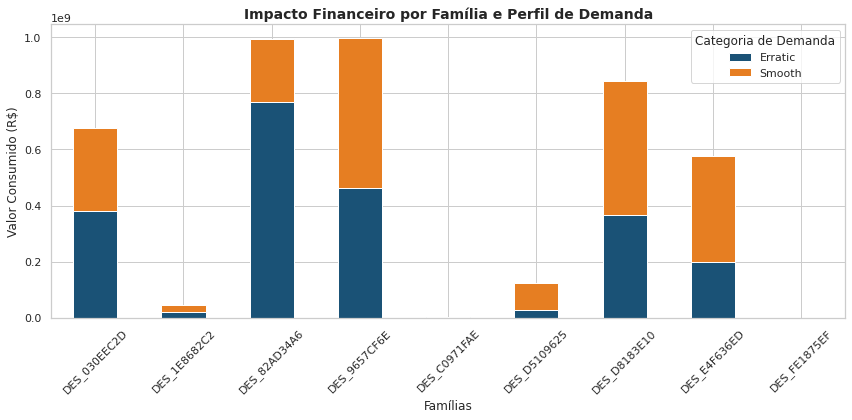

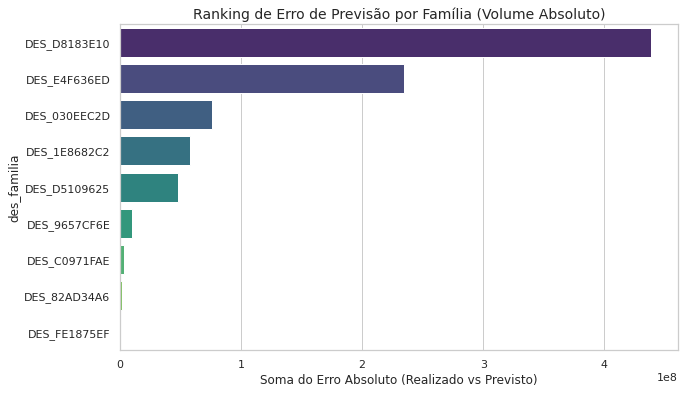

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregando dados (Conversão para Pandas para plotagem)
df = spark.read.table("sandbox.consumo_material_base").toPandas()
df['ano_mes'] = pd.to_datetime(df['ano_mes'])

# 2. Gráfico: Mix de Categoria por Família (Risco Operacional)
# Como são apenas 2 categorias, o gráfico de barras empilhadas mostra onde está a "instabilidade"
plt.figure(figsize=(12, 6))
ct = pd.crosstab(df['des_familia'], df['des_categoria_demanda'], 
                 values=df['vlr_consumo_realizado'], aggfunc='sum')

ct.plot(kind='bar', stacked=True, color=['#1A5276', '#E67E22'], figsize=(12,6))
plt.title('Impacto Financeiro por Família e Perfil de Demanda', fontsize=14, fontweight='bold')
plt.ylabel('Valor Consumido (R$)')
plt.xlabel('Famílias')
plt.xticks(rotation=45)
plt.legend(title='Categoria de Demanda')
plt.tight_layout()
plt.show()

# 3. Gráfico: Eficiência do Planejamento (Acuracidade)
# Calculando a variação absoluta para ver quem erra mais a mão
df['erro_abs'] = (df['qtd_realizada'] - df['qtd_prevista']).abs()
df_erro = df.groupby('des_familia')['erro_abs'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=df_erro.values, y=df_erro.index, palette='viridis')
plt.title('Ranking de Erro de Previsão por Família (Volume Absoluto)', fontsize=14)
plt.xlabel('Soma do Erro Absoluto (Realizado vs Previsto)')
plt.show()

##VARIABILIDADE DO ERRO POR FAMÍLIA

<Figure size 864x504 with 0 Axes>

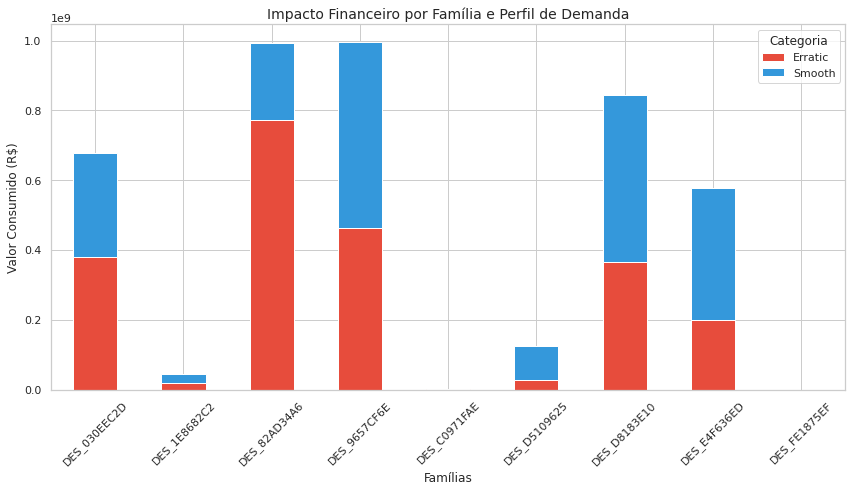

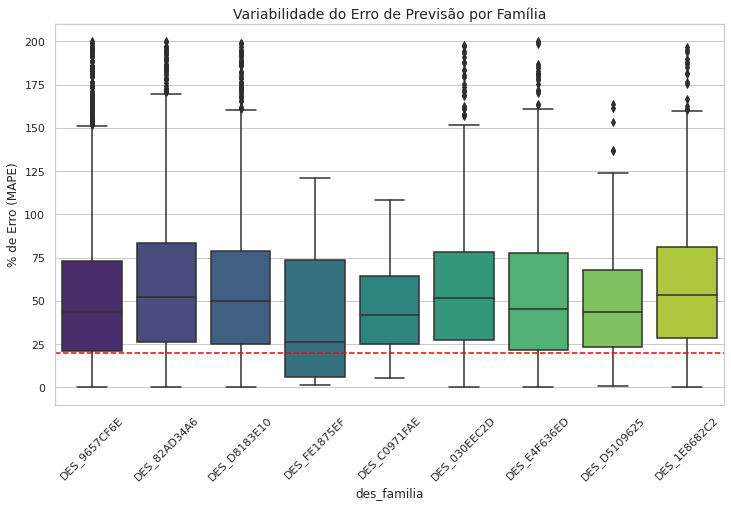

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando os dados
df = spark.read.table("sandbox.consumo_material_base").toPandas()
df['ano_mes'] = pd.to_datetime(df['ano_mes'])

# 1. Gráfico de Composição por Família e Categoria
plt.figure(figsize=(12, 7))
ct = pd.crosstab(df['des_familia'], df['des_categoria_demanda'], values=df['vlr_consumo_realizado'], aggfunc='sum')
ct.plot(kind='bar', stacked=True, color=['#e74c3c', '#3498db'], figsize=(12,7))
plt.title('Impacto Financeiro por Família e Perfil de Demanda', fontsize=14)
plt.ylabel('Valor Consumido (R$)')
plt.xlabel('Famílias')
plt.xticks(rotation=45)
plt.legend(title='Categoria')
plt.tight_layout()
plt.show()

# 2. Erro de Previsão por Família (Boxplot)
plt.figure(figsize=(12, 7))
df['erro_percentual'] = ((df['qtd_realizada'] - df['qtd_prevista']).abs() / df['qtd_prevista']) * 100
# Filtrando outliers extremos para o gráfico ficar legível
sns.boxplot(data=df[df['erro_percentual'] < 200], x='des_familia', y='erro_percentual', palette='viridis')
plt.axhline(20, ls='--', color='red', label='Limite Aceitável (20%)')
plt.title('Variabilidade do Erro de Previsão por Família', fontsize=14)
plt.ylabel('% de Erro (MAPE)')
plt.xticks(rotation=45)
plt.show()